In [1]:
import numpy as np
from scipy import misc as misc
import tensorflow as tf
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
tf.set_random_seed(777)
tmp = np.load('./data2.npz')
train_img = tmp['train_img']
train_lab = tmp['train_lab']

In [3]:
num_classes = 2
X = tf.placeholder(tf.float32, shape=[None, 224,224,3])
Y = tf.placeholder(tf.float32, shape=[None, num_classes])
keep = tf.placeholder(tf.float32)

In [4]:
weights = {
    'wc1' : tf.get_variable('wc1', [7, 7, 3, 96], dtype=tf.float32, 
                            initializer=tf.contrib.layers.xavier_initializer()),    # 240
    'wc2' : tf.get_variable('wc2', [5, 5, 96, 256], dtype=tf.float32, 
                            initializer=tf.contrib.layers.xavier_initializer()),   # 120
    'wc3' : tf.get_variable('wc3', [3, 3, 256, 512], dtype=tf.float32, 
                            initializer=tf.contrib.layers.xavier_initializer()),   # 60
    'wc4' : tf.get_variable('wc4', [3, 3, 512, 512], dtype=tf.float32, 
                            initializer=tf.contrib.layers.xavier_initializer()),  # 30
    'wc5' : tf.get_variable('wc5', [3, 3, 512, 512], dtype=tf.float32, 
                            initializer=tf.contrib.layers.xavier_initializer()), # 15
    'wd1' : tf.get_variable('wd1', [13*13*512, 4048], dtype=tf.float32, 
                            initializer=tf.contrib.layers.xavier_initializer()),
    'wd2' : tf.get_variable('wd2', [4048, 4049], dtype=tf.float32, 
                            initializer=tf.contrib.layers.xavier_initializer()),
    'wd3' : tf.get_variable('wd3', [4049, num_classes], dtype=tf.float32, 
                            initializer=tf.contrib.layers.xavier_initializer())
}

biases = {
    'bc1' : tf.Variable(tf.zeros([96]), trainable=False, dtype=tf.float32),
    'bc2' : tf.Variable(tf.zeros([256]), trainable=False, dtype=tf.float32),
    'bc3' : tf.Variable(tf.zeros([512]), trainable=False, dtype=tf.float32),
    'bc4' : tf.Variable(tf.zeros([512]), trainable=False, dtype=tf.float32),
    'bc5' : tf.Variable(tf.zeros([512]), trainable=False, dtype=tf.float32),
    'bd1' : tf.Variable(tf.zeros([4048]), trainable=False, dtype=tf.float32),
    'bd2' : tf.Variable(tf.zeros([4049]), trainable=False, dtype=tf.float32),
    'bd3' : tf.Variable(tf.zeros([num_classes]), trainable=False, dtype=tf.float32)
}

In [5]:
def model(x, w, b, k):
    
    conv1 = tf.nn.conv2d(x, w['wc1'], strides=[1, 1, 1, 1], padding='SAME')
    act1 = tf.nn.relu(conv1 + b['bc1'])
    pool1 = tf.nn.max_pool(act1, ksize=[1, 3, 3, 1], strides=[1, 3, 3, 1], padding='SAME')
    conv2 = tf.nn.conv2d(pool1, w['wc2'], strides=[1, 1, 1, 1], padding='SAME')
    act2 = tf.nn.relu(conv2 + b['bc2'])
    pool2 = tf.nn.max_pool(act2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    
    conv3 = tf.nn.conv2d(pool2, w['wc3'], strides=[1, 1, 1, 1], padding='SAME')
    act3 = tf.nn.relu(conv3 + b['bc3'])
    
    conv4 = tf.nn.conv2d(conv3, w['wc4'], strides=[1, 1, 1, 1], padding='SAME')
    act4 = tf.nn.relu(conv4 + b['bc4'])
    
    conv5 = tf.nn.conv2d(conv4, w['wc5'], strides=[1, 1, 1, 1], padding='SAME')
    act5 = tf.nn.relu(conv5 + b['bc5'])
    pool5 = tf.nn.max_pool(act5, ksize=[1, 3, 3, 1], strides=[1, 3, 3, 1], padding='SAME')
    #print(pool5.shape)
    flat = tf.reshape(pool5, [-1, 13*13*512])
    
    act6 = tf.nn.relu(tf.matmul(flat, w['wd1'])+b['bd1'])
    drop1 = tf.nn.dropout(act6, keep_prob=k)
    
    act7 = tf.nn.relu(tf.matmul(drop1, w['wd2'])+b['bd2'])
    drop2 = tf.nn.dropout(act7, keep_prob=k)
    
    output = tf.matmul(drop2, w['wd3'])+b['bd3']
    
    out = {
        'act1':act1,
        'act2':act2,
        'act3':act3,
        'act4':act4,
        'act5':act5,
        'act6':act6,
        'act7':act7,
        'output':output
        
    }
    
    
    return out

In [6]:
pred = model(X, weights, biases, keep)

In [7]:
cost= tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred['output'], labels=Y))

train = tf.train.AdamOptimizer(0.0001).minimize(cost)

collect = tf.equal(tf.argmax(pred['output'], axis=1), tf.argmax(Y, axis=1))

accuracy = tf.reduce_mean(tf.cast(collect, tf.float32))

In [8]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()
saver.restore(sess, './checkpoint/')

INFO:tensorflow:Restoring parameters from ./checkpoint/


In [9]:
def infer(x):
    softmax = tf.nn.softmax(pred['output'])
    return sess.run(softmax, feed_dict={X:x, keep:1.0})

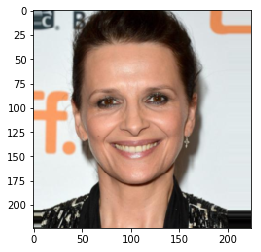

[[ 0.32283872  0.67716134]]


In [10]:
num = 100
plt.imshow(train_img[num,:,:,:])
plt.show()

print(infer(np.reshape(train_img[num,:,:,:], [1, 224,224,3])))

In [11]:
import glob
test_dir = glob.glob('/data1/jerry/face/data/test/*.jpg')

#[1, 0] Non_emotion
for i in test_dir:
    test = misc.imread(i)
    test = misc.imresize(test, [224,224,3])
    test = np.reshape(test, [1,224,224,3])
    plt.imshow(test[0])
    plt.show()
    result = infer(test)
    print(result[0][0])
    print(result[0][1], '\n')

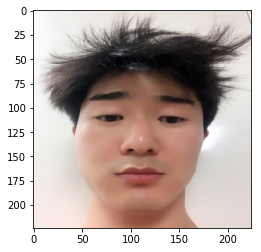

0.703292
0.296708 

0


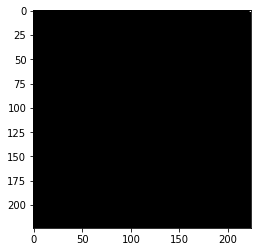

1


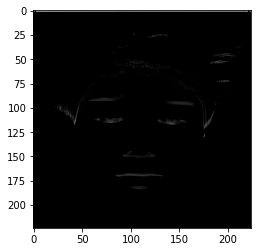

2


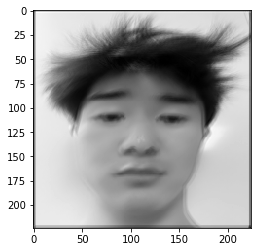

3


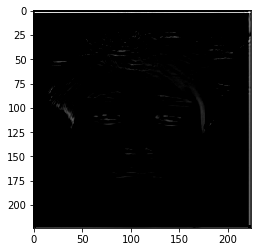

4


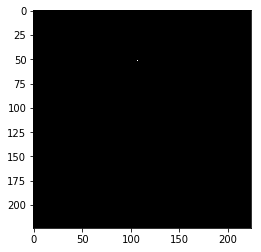

5


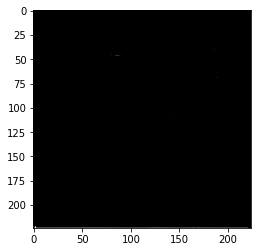

6


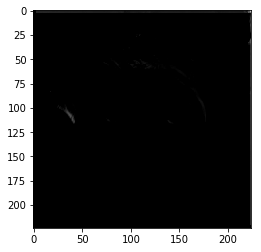

7


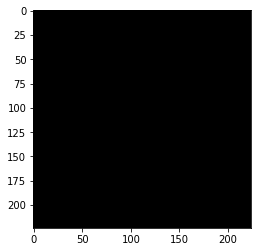

8


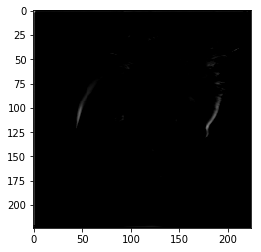

9


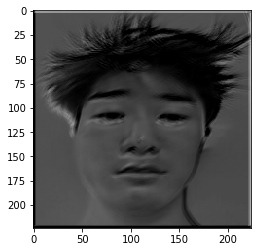

10


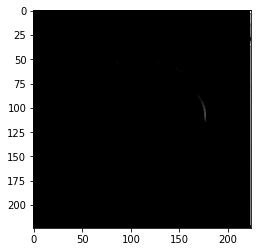

11


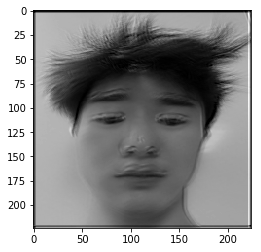

12


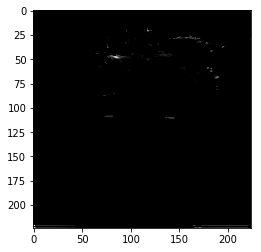

13


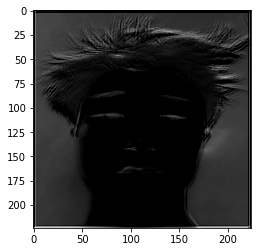

14


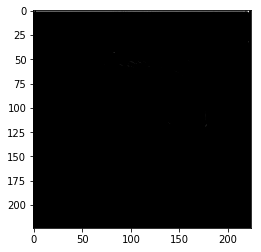

15


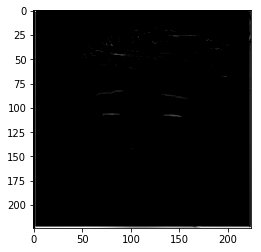

16


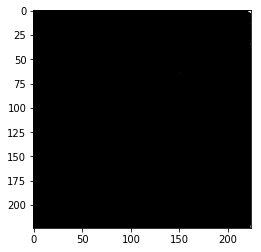

17


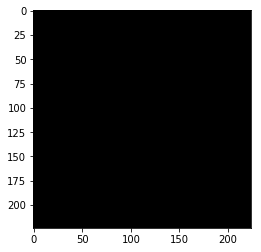

18


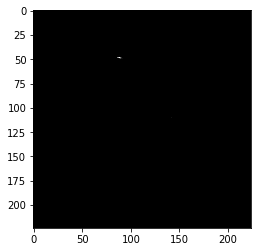

19


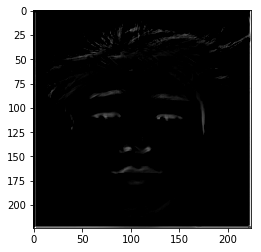

20


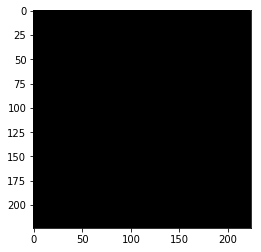

21


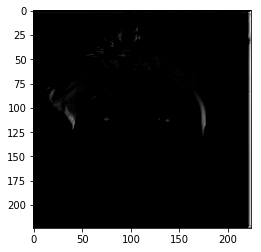

22


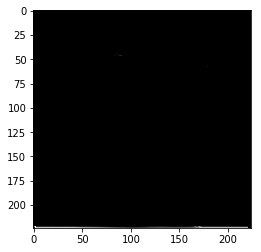

23


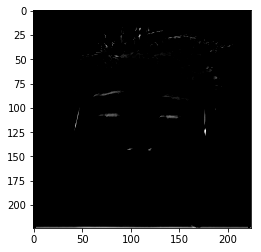

24


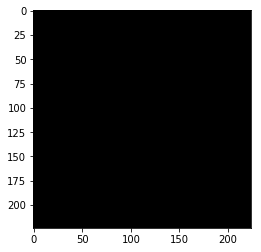

25


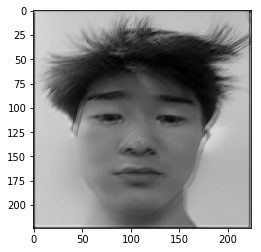

26


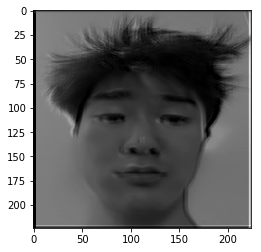

27


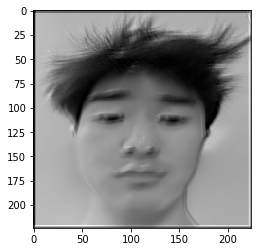

28


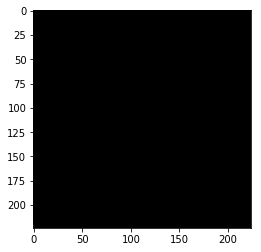

29


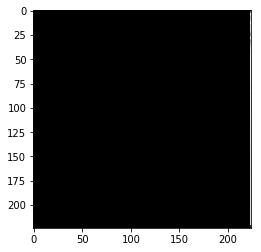

30


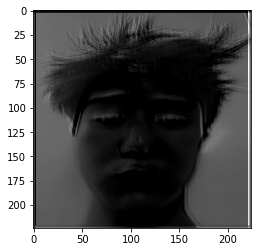

31


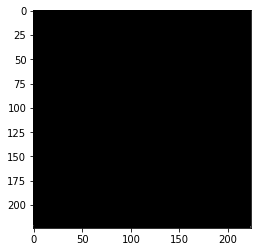

32


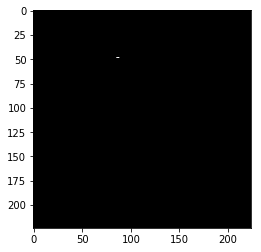

33


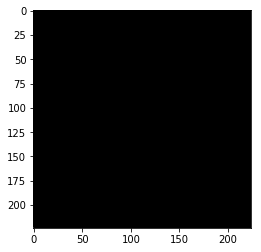

34


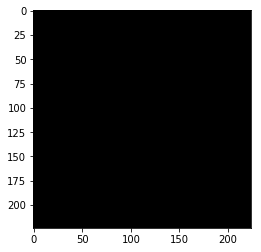

35


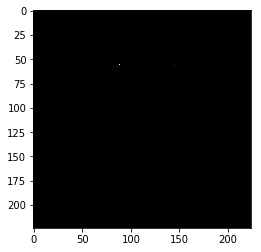

36


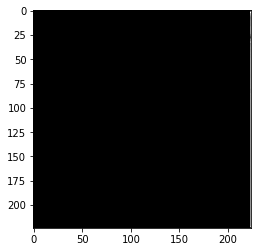

37


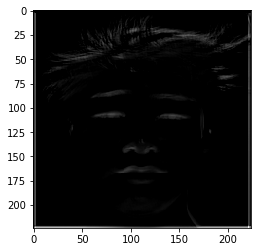

38


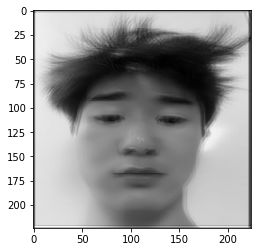

39


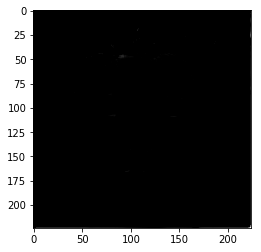

40


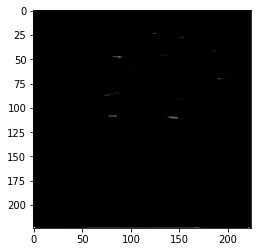

41


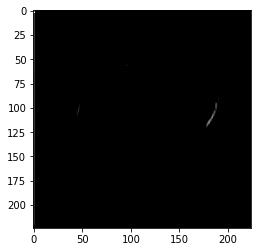

42


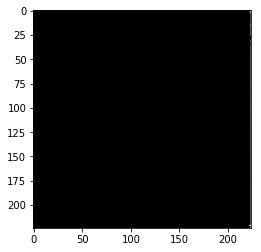

43


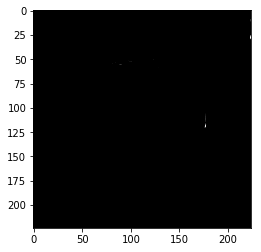

44


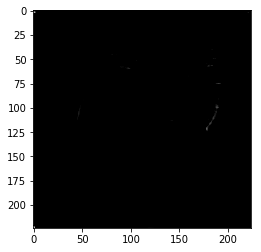

45


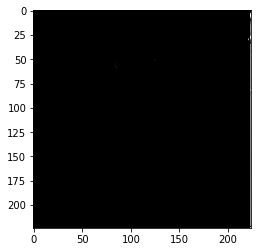

46


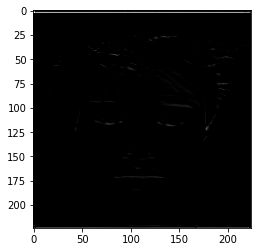

47


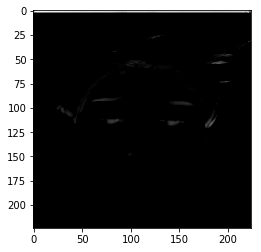

48


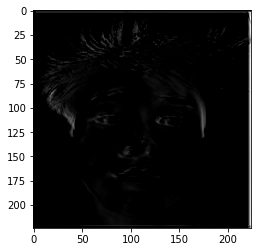

49


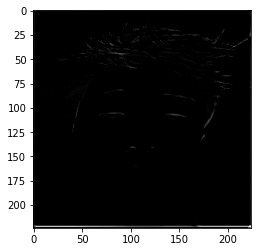

50


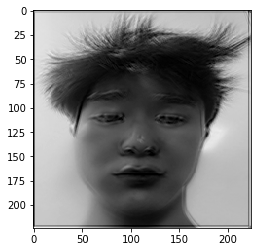

51


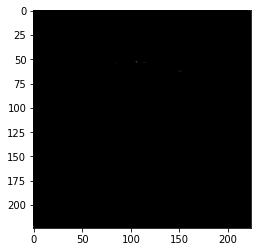

52


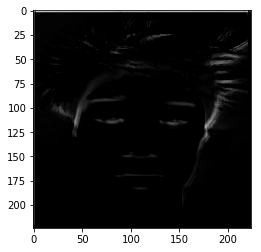

53


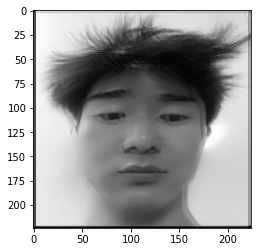

54


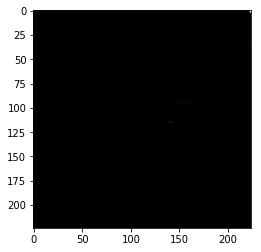

55


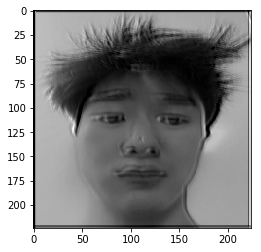

56


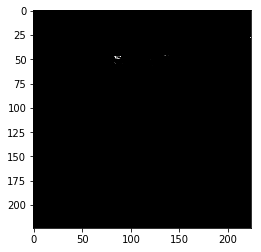

57


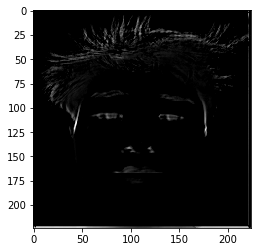

58


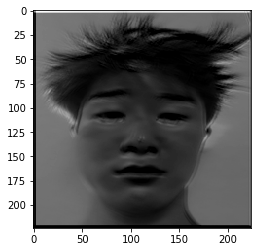

59


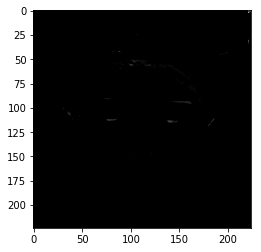

60


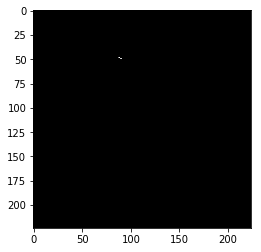

61


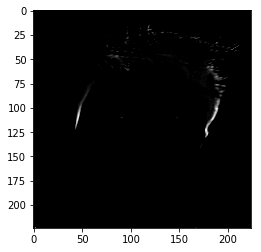

62


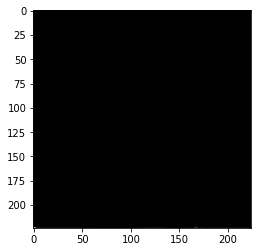

63


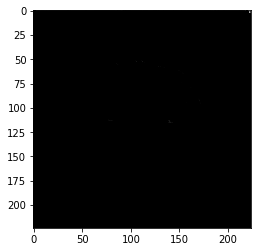

64


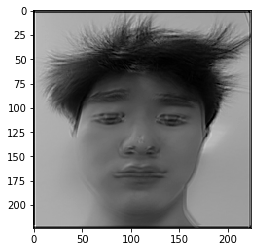

65


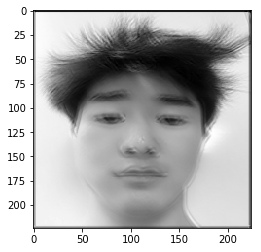

66


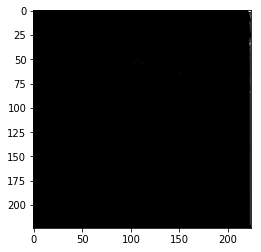

67


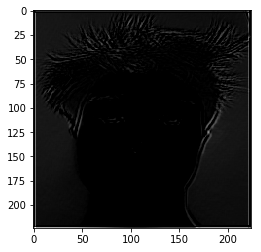

68


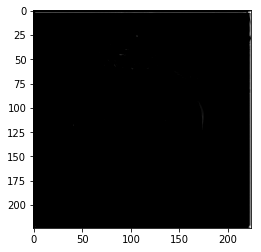

69


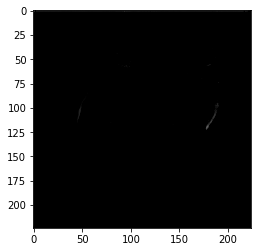

70


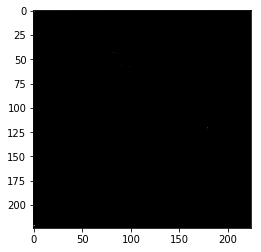

71


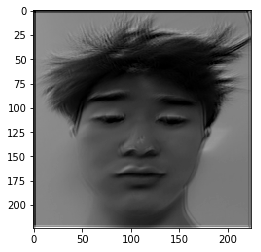

72


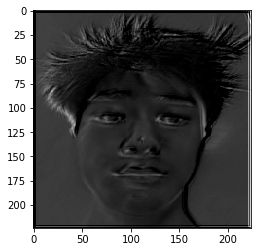

73


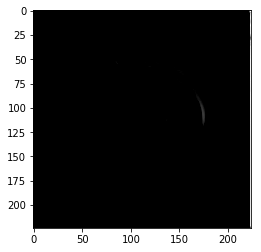

74


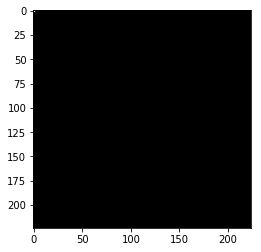

75


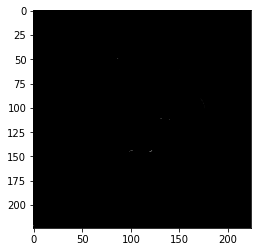

76


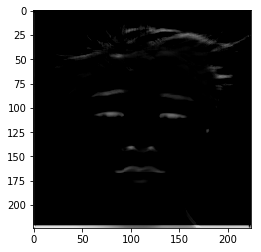

77


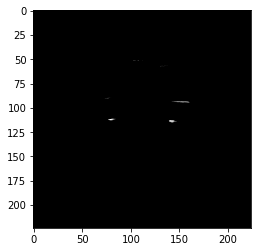

78


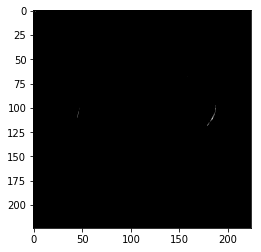

79


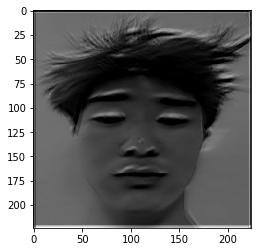

80


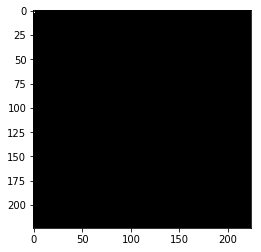

81


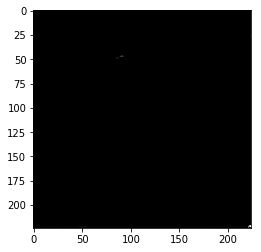

82


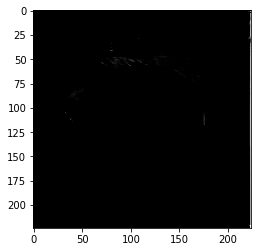

83


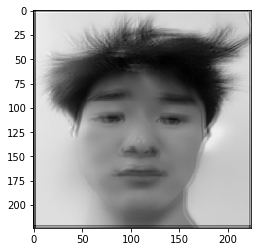

84


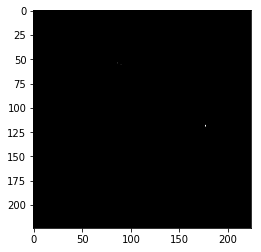

85


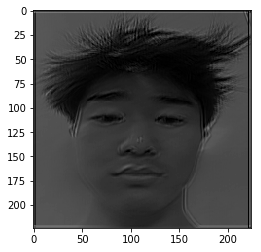

86


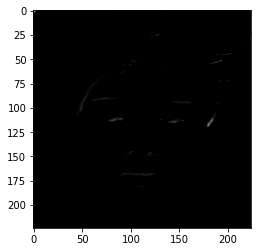

87


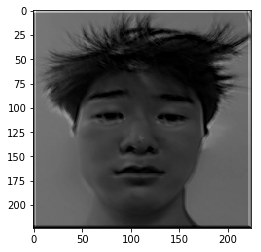

88


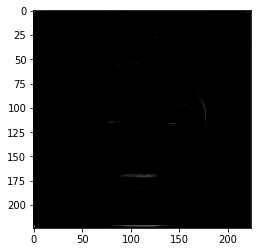

89


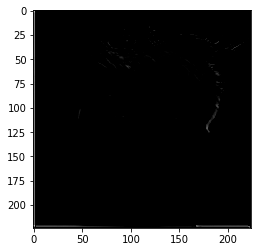

90


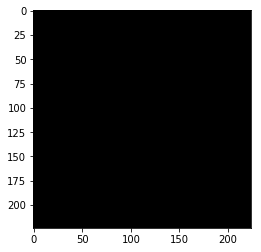

91


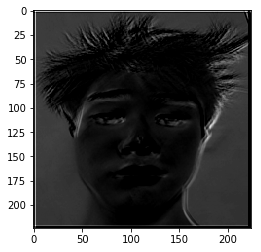

92


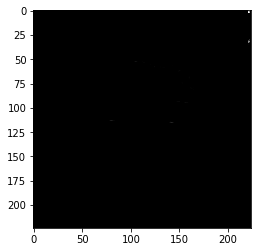

93


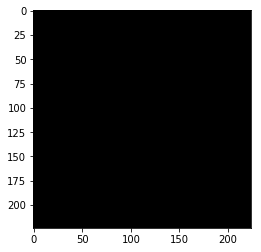

94


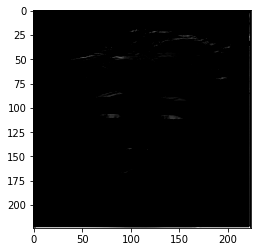

95


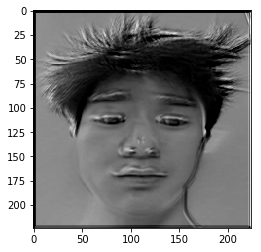

In [12]:
test = misc.imread(test_dir[1])
test = misc.imresize(test, [224,224,3])
test = np.reshape(test, [1,224,224,3])
plt.imshow(test[0])
plt.show()
result = infer(test)
print(result[0][0])
print(result[0][1], '\n')
view = sess.run(pred, feed_dict={X:test, keep:1.0})
for i in range(view['act1'].shape[3]):
    print(i)
    plt.imshow(view['act1'][0,:,:,i], cmap='gray')
    plt.show()